In [1]:
#### ------------------------------------------------------------------------------------
#### Use scanpy.yml environment
#### If looking to propagate labels for a larger dataset, 
#### see `propagate_labels()` function in `coexist/utilslib/utils.py` 
#### for GPU implementation of KNN label propagation
#### -------------------------------------------------------------------------------------

import os
import re 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier

### Propagating tracked labels to untracked cells on the immune panel

In [2]:
## inputs 
# spatial coords 
immune_spatial = pd.read_csv('../data/E06_immune_spatial.csv')

# cell type annotations 
immune_annots_df = pd.read_csv(f'../annotations/E06_immune_annotations.csv')
immune_annots_map = pd.Series(immune_annots_df.cell_type_refined.values, index = immune_annots_df.cluster).to_dict()

tracked_annots_df = pd.read_csv(f'../annotations/E06_tracked_annotations.csv')
tracked_annots_map = pd.Series(tracked_annots_df.cell_type_refined.values, index = tracked_annots_df.cluster).to_dict()

# data files
immune = pd.read_csv('../data/E06_immune_indiv_leiden.csv')
tracked = pd.read_csv('../data/E06_tracked_indiv_leiden.csv')

In [3]:
# map cell types to leiden clusters 
immune['cell_type_immune'] = immune['leiden'].map(immune_annots_map)
tracked['cell_type_tracked'] = tracked['leiden'].map(tracked_annots_map)

# merge cluster assignments from immune panels into tracked data 
tracked = pd.merge(tracked, immune[['CellID','cell_type_immune']], left_on = 'immune_CellID', right_on = 'CellID')

# merge spatial coords into immune dataframe 
immune = pd.merge(immune, immune_spatial, on = 'CellID')

# set CellID as index 
immune_sub = immune.set_index('CellID')

# subset to markers
immune_markers = ['CD3', 'GRZB', 'Ki67', 'PanCK', 'CD45', 'CD68', 'CD3d', 'CD8a',
       'CD163', 'aSMA', 'CD14', 'CD4', 'FOXP3', 'CD11b', 'CD20', 'MHC_II_DPB1']

immune_sub = immune_sub[immune_markers]

In [4]:
immune_sub

,CD3,GRZB,Ki67,PanCK,CD45,CD68,CD3d,CD8a,CD163,aSMA,CD14,CD4,FOXP3,CD11b,CD20,MHC_II_DPB1
CellID,,,,,,,,,,,,,,,,
4,0.366037,0.350727,0.277419,0.805565,0.357778,0.270825,0.229091,0.387657,0.362896,0.262353,0.581826,0.618315,0.186075,0.335942,0.099357,0.087389
9,0.357832,0.319547,0.281141,0.842282,0.402648,0.240431,0.158038,0.282488,0.268765,0.148173,0.480777,0.575136,0.141379,0.358801,0.097848,0.098802
14,0.401117,0.320448,0.355738,0.871291,0.310766,0.259524,0.209596,0.296994,0.304173,0.166507,0.454622,0.622967,0.176319,0.366310,0.120087,0.106611
16,0.397872,0.300328,0.515549,0.858183,0.349033,0.289496,0.249567,0.327053,0.346273,0.217006,0.509630,0.614789,0.146828,0.355978,0.102957,0.101852
18,0.373430,0.338751,0.321335,0.803672,0.343630,0.296496,0.288619,0.344712,0.364496,0.200554,0.551485,0.663678,0.222652,0.372049,0.132435,0.119839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13288,0.546070,0.410350,0.644927,0.770384,0.321220,0.418909,0.407342,0.395011,0.568381,0.381506,0.710558,0.683976,0.404230,0.485761,0.388593,0.278127
13289,0.596106,0.353173,0.356829,0.808733,0.345920,0.395603,0.416131,0.465239,0.528186,0.237382,0.691904,0.678030,0.389759,0.411906,0.286540,0.176091
13292,0.416251,0.372160,0.386964,0.352172,0.671593,0.337114,0.294517,0.281715,0.424986,0.347064,0.754802,0.863997,0.327986,0.582178,0.263002,0.277769


In [ ]:
# split into tracked and untracked 
immune_tracked = immune_sub[immune_sub.index.isin(tracked['immune_CellID'])]
immune_untracked = immune_sub[~immune_sub.index.isin(tracked['immune_CellID'])]

# grab the labels to train on from the labeled annotations 
label_df = pd.merge(
    immune_tracked, 
    tracked[['immune_CellID','cell_type_tracked']],
    left_index = True,
    right_on = 'immune_CellID')

labs = label_df['cell_type_tracked']

# train, fit, predict KNN 
model = KNeighborsClassifier(n_neighbors=10)
model.fit(immune_tracked, labs)
y_hat = model.predict(immune_untracked)

# assign predicted labels 
immune_tracked['cross_cluster'] = list(labs)
immune_untracked['cross_cluster'] = list(y_hat)

# recombined tracked and untracked cells 
recombined_df = pd.concat([immune_tracked, immune_untracked])

# merge with spatial 
recombined_df.reset_index()
recombined_df = pd.merge(recombined_df, immune_spatial, on = 'CellID')

# merge immune cell type into recombined_df 
recombined_df = pd.merge(recombined_df, immune[['CellID','cell_type_immune']], on = 'CellID')

In [ ]:
recombined_df.to_csv('data/E06_immune_label_propagated_spatial.csv', index = False)

### Propagating tracked labels to untracked cells on the tumor panel

In [ ]:
## inputs 
# spatial coords 
tumor_spatial = pd.read_csv('data/E06_tumor_spatial.csv')

# cell type annotations 
tumor_annots_df = pd.read_csv(f'annotations/E06_tumor_annotations.csv')
tumor_annots_map = pd.Series(tumor_annots_df.cell_type_refined.values, index = tumor_annots_df.cluster).to_dict()

tracked_annots_df = pd.read_csv(f'annotations/E06_tracked_annotations.csv')
tracked_annots_map = pd.Series(tracked_annots_df.cell_type_refined.values, index = tracked_annots_df.cluster).to_dict()

# data files
tumor = pd.read_csv('data/E06_tumor_indiv_leiden.csv')
tracked = pd.read_csv('data/E06_tracked_indiv_leiden.csv')

In [ ]:
# map cell types to leiden clusters 
tumor['cell_type_tumor'] = tumor['leiden'].map(tumor_annots_map)
tracked['cell_type_tracked'] = tracked['leiden'].map(tracked_annots_map)

# merge cluster assignments from tumor panels into tracked data 
tracked = pd.merge(tracked, tumor[['CellID','cell_type_tumor']], left_on = 'tumor_CellID', right_on = 'CellID')

# merge spatial coords into tumor dataframe 
tumor = pd.merge(tumor, tumor_spatial, on = 'CellID')

# set CellID as index 
tumor_sub = tumor.set_index('CellID')

# subset to markers
tumor_markers = ['CD3',  'Vimentin', 'aSMA', 'Ecad', 'Ki67', 'CD45', 
           'CK14', 'CK19', 'CK17', 'PCNA', 'PanCK', 'CD31']

tumor_sub = tumor_sub[tumor_markers]

In [ ]:
# split into tracked and untracked 
tumor_tracked = tumor_sub[tumor_sub.index.isin(tracked['tumor_CellID'])]
tumor_untracked = tumor_sub[~tumor_sub.index.isin(tracked['tumor_CellID'])]

# grab the labels to train on from the labeled annotations 
label_df = pd.merge(
    tumor_tracked, 
    tracked[['tumor_CellID','cell_type_tracked']],
    left_index = True,
    right_on = 'tumor_CellID')

labs = label_df['cell_type_tracked']

# train, fit, predict KNN 
model = KNeighborsClassifier(n_neighbors=10)
model.fit(tumor_tracked, labs)
y_hat = model.predict(tumor_untracked)

# assign predicted labels 
tumor_tracked['cross_cluster'] = list(labs)
tumor_untracked['cross_cluster'] = list(y_hat)

# recombined tracked and untracked cells 
recombined_df = pd.concat([tumor_tracked, tumor_untracked])

# merge with spatial 
recombined_df.reset_index()
recombined_df = pd.merge(recombined_df, tumor_spatial, on = 'CellID')

# merge tumor cell type into recombined_df 
recombined_df = pd.merge(recombined_df, tumor[['CellID','cell_type_tumor']], on = 'CellID')

In [ ]:
recombined_df.to_csv('data/E06_tumor_label_propagated_spatial.csv', index = False)

### Create spatial scatter plots of pre- and post-label propagation (Figure 3D)

In [2]:
# cell type colors for consistency across figures 
cell_type_colors = {
    'Epithelial' : '#d60000', 
    'Basal Epithelial' : '#8c3bff', 
    'Proliferative Epithelial' : '#018700',
    'Proliferative Basal Epithelial' : '#00acc6', 
    'Myoepithelial' : '#97ff00', 
    'Stroma' : '#ff7ed1', 
    'Endothelial' : '#6b004f',
    'aSMA+ Stroma' : '#ffa52f', 
    'B-cells' : '#00009c',
    'T-cells' : '#857067', 
    'CD8+ T-cells' : '#004942', 
    'CD4+ T-cells' : '#4f2a00',
    'Regulatory T-cells' : '#00fdcf', 
    'Macrophages' : '#bcb6ff',
    'CD163+ Macrophages' : '#95b379'   
}

In [4]:
immune = pd.read_csv('../data/E06_immune_label_propagated_spatial.csv')
tumor = pd.read_csv('../data/E06_tumor_label_propagated_spatial.csv')

In [5]:
immune.columns = ['CellID', 'CD3', 'GRZB', 'Ki67', 'PanCK', 'CD45', 'CD68', 'CD3d',
       'CD8a', 'CD163', 'aSMA', 'CD14', 'CD4', 'FOXP3', 'CD11b', 'CD20',
       'MHC_II_DPB1', 'cross_cluster', 'x', 'y', 'cell_type_individual']

In [6]:
tumor.columns = ['CellID', 'CD3', 'Vimentin', 'aSMA', 'Ecad', 'Ki67', 'CD45', 'CK14',
       'CK19', 'CK17', 'PCNA', 'PanCK', 'CD31', 'cross_cluster', 'x', 'y',
       'cell_type_individual']

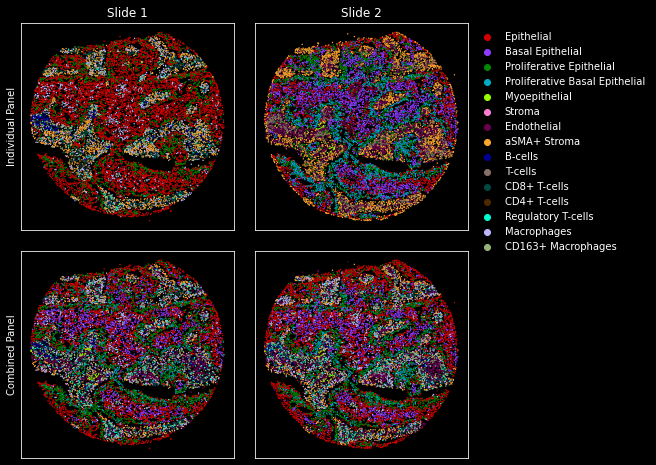

In [ ]:
plt.style.use("dark_background")
fig,ax = plt.subplots(
    ncols=2, 
    nrows=2, 
    gridspec_kw={'wspace' : 0.1, 'hspace' : 0.1},
    figsize = (8,8))

panels = [immune, tumor]
labels = ['cell_type_individual','cross_cluster']

for i,p in enumerate(panels):
    for j,l in enumerate(labels):

        sns.scatterplot(
            x = p['y'], 
            y = p['x'], 
            hue = p[l],
            palette = cell_type_colors,
            hue_order = list(cell_type_colors.keys()),
            linewidth = 0,
            s = 2,
            ax = ax[j,i])

        ax[j,i].invert_xaxis()
        # ax[j,i].set_aspect('equal')
        ax[j,i].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False) 
        ax[j,i].set_ylabel('')
        ax[j,i].set_xlabel('')


        ax[j,i].get_legend().set_visible(False)


ax[0,0].set_title('Slide 1')
ax[0,1].set_title('Slide 2')

ax[0,0].set_ylabel('Individual Panel')
ax[1,0].set_ylabel('Combined Panel')

ax[0,1].get_legend().set_visible(True)
sns.move_legend(ax[0,1], bbox_to_anchor=(1,1), loc='upper left', frameon=False)
ax[0,1].get_legend().set_title(None)

# plt.tight_layout()
# plt.subplots_adjust(right=0.8)

plt.savefig('Figure_4E.png', dpi = 500, bbox_inches='tight')